# Cell count demo

Welcome!!<br><br>
In this notebook, I will demonstrate three methods to perform a simple cell couting tasks and compare the results.  
The methods are;
- Classical algorithm-based approach with theresholding and watersheding (written in Python)
- Deep learning-based approach (CellPose)
- ImageJ macro-based approach

Firstly, we will run these methods on a single image and examine how well it works.  
Secondly, we will make a proliferation curve based on the python algorithm and imageJ macro with three randomly selected compounds. For the imageJ macro, cell area quantifications will be considered as well.  
A short summary will be provided at the last of the notebook.

Ok, let's import necessary packages. Please install them according to README if necessary.

In [1]:
%load_ext autoreload
%autoreload 2

import glob
from textwrap import wrap

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scripts import cell_count_contour
from cellpose import models

And setting up paths

In [2]:
img_dir = "./imgs/DAPI"
meta_pth = "meta/BBBC021_v1_image_wMoAs.csv"

## Dataset

In this demostration, we will use a subset of images from the BBBC021 dataset. In the dataset, MCF-7 breast cancer cells were treated for 24 hours with different small molecules at eight concentrations. For more details, please refer to the [original website](https://bbbc.broadinstitute.org/BBBC021).


Input image datasets for this notebook have more than 700MB in total. Therefore, they are not included git tracking.<br>
To set up the dataset, simply please go to [google drive](https://drive.google.com/file/d/1JVsH4ppMGh87VnmPZBnpMsN0LbuWOwI7/view?usp=sharing), download and extract the files. You'll have `imgs/DAPI` directory extracted, so please locate them in you local under `cell_count_demo/imgs/DAPI`.

### Raw images

Let's check a few example of raw images. Here we list three images of emetine treatment from different concentrations.<br>
Images are from DAPI channel and as you could see the number of nuclei and its moprhology change as the concentration increases.

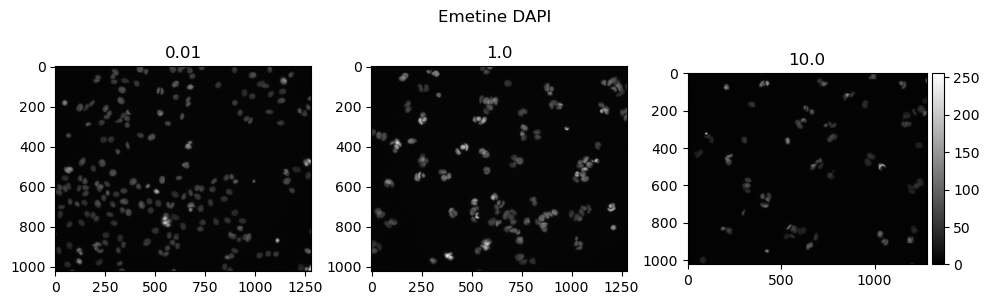

In [3]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
cntrs = ["0.01", "1.0", "10.0"]
for i, cntr in enumerate(cntrs):
    img_pth = glob.glob(f"{img_dir}/emetine/{cntr}/*.tif")[0]
    img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)
    img = (((img - img.min())/(img.max() - img.min()))*255).astype(np.uint8)
    _ = ax[i].imshow(img, vmin=0, vmax=255, cmap='gray')
    ax[i].set_title(cntr)
divider = make_axes_locatable(fig.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(_, cax=cax); plt.suptitle("Emetine DAPI")
plt.tight_layout(); plt.show(); plt.close('all')

## Cell counting

### Python - algorithm based

Using the above image of 0.01 concentration, we can demostrate cell counting methods.<br>
The first one is a simple python function based on thresholding, smoothing and contouring. It takes a path to an image, open it and covert it to 8-bit image first (left image). Then, set the threshold value with `mash_th` argument, where all pixel value to be set 255 above this value, and apply the gaussian blur with sigma=5 (center picture). Finaly, compute the contours based on the `cnt_th` argument and plot them in blue outer line (right image). Number of nucleus can be approximated by the number of set of contours.<br>
With the below set parameters, the number of nucleus is estimated 168. By following the image transition from the left to right, it seems the function does a reasonable job.

Number of cells: 168


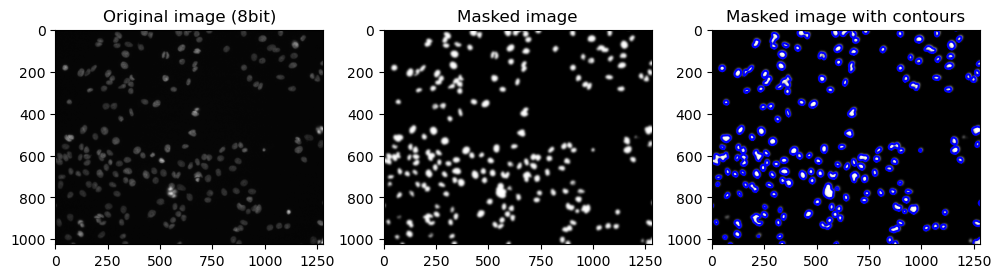

<Figure size 640x480 with 0 Axes>

In [4]:
img_pth = glob.glob(f"{img_dir}/emetine/0.01/*.tif")[0]
cnts, fig = cell_count_contour(img_pth, mask_th=40, cnt_th=125, show_plot=True, verbouse=True)

## Python - deep-learning based

We use `CellPose` from Stringer et al. 2021 for deep learning based segmentation. The advantage of CellPose is not to require model retraining or hyper parameter adjustment. This makes it easier to have a quick try on arbitrary cell image data.<br>
The only hyperparameter needs to be tweeked is `diameter` here. Changing its value directly affects the segmentation result. For more information and installation setup, please refer to their [github page](https://github.com/MouseLand/cellpose).

Great job! As you could see on the right plot below, it segments the cells with a precise quality that makes the resulting cell counts a little higher. 

Number of cells: 215


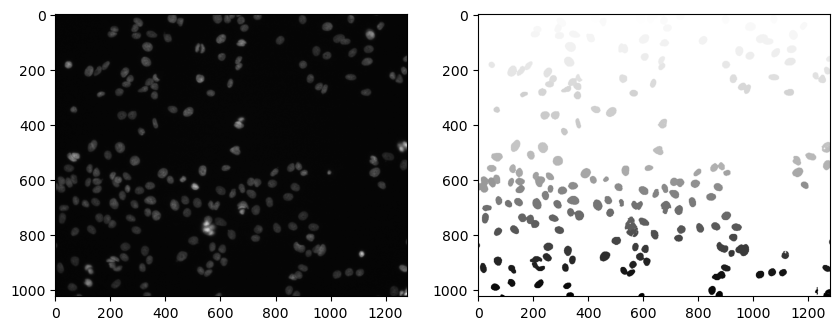

In [5]:
img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)
img_8bit = ((img - img.min()) / (img.max() - img.min())) * 255

model = models.Cellpose(gpu=False, model_type='nuclei') # model_type='cyto' or model_type='nuclei'

# Running the models
masks, flows, styles, diams = model.eval(img_8bit, diameter=60, flow_threshold=None, channels=[0,0])
print(f"Number of cells: {len(np.unique(masks))}")

# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_8bit, vmin=0, vmax=255, cmap='gray')
ax[1].imshow(masks,cmap='Greys')
plt.show()


## ImageJ based

Finally, we use imageJ macro to do the same task. Running `cell_cnts_single.ijm` scipt in ImageJ will save the results of cell counting and area measurement. First we pre-compute the results and save them with ImageJ. And with below script, we grab them and plot the results.<br>
This also does a pretty decent job. Since we perform a similar set of methods inside for both python based algorithm and this ImageJ macro, the both results are quite resembled.

Note: When you run `cell_cnts_single.ijm`, it will ask you a path of single image and output directory to save the result. In some cases, the dialogue message are not properly popped up in ImageJ. But you'll figure out easily which dialogue corresponds to which.<br>
To get the same result, please specify the path of `./imgs/DAPI/emetine/0.01/Week3_290607_C10_s2_w14A4A3A02-57AA-4A68-B11C-ED3364ACC653.tif` for the input image (first prompt) and make `outs/single` directory under the project root and use it as the output directory (second prompt).  

Number of cells: 170


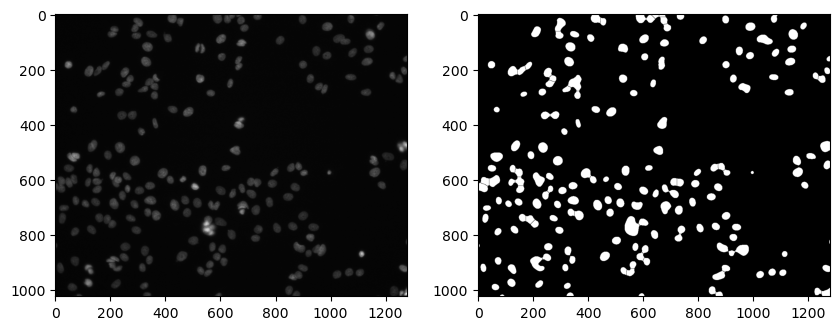

In [7]:
pth = "./outs/single"  # Please change here according to your saving directory
csv_pth = glob.glob(f"{pth}/*.csv")[0]
df = pd.read_csv(csv_pth, index_col=0)
print(f"Number of cells: {df.shape[0]}")
img_pths = glob.glob(f"{pth}/*.tif")
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i, ip in enumerate(img_pths):
    img = cv2.imread(ip, cv2.IMREAD_UNCHANGED)
    img = ((img - img.min()) / (img.max() - img.min())) * 255
    ax[i].imshow(img, cmap="gray")


## 2. Image-based proliferation curve

Now we know how to get the cell counts in an image with different methods. We can apply them repeatedly for a set of images to approximate the proliferation curve of different treatment.<br>
In our dataset, there are mostly 12 images per treatment (e.g. emetine with 0.01 micromolar dose has 3 replicates x 4 fields = 12 images) and 8 concentrations per compound. Therefore, computing the cell counts per image and plotting them per concentration would give us an approximation of the drug's potency curve.

As an exmaple, we pick up three compounds "staurosporine", "emetine", and "etoposide".

In [8]:
meta = pd.read_csv(meta_pth)
cpds = ["staurosporine", "emetine", "etoposide"]

### Python algorithm based

Below the script is using the same function `cell_count_contour` that we used above for a single image but repeatedly apply it.<br>
We collect cell counts for all images and plot them per compound, where the concentration is on the x-axis and the number of cells is on the y-axis.<br>
We can see a nice descreasing curve which can be used for an apporximation of IC50 or potency curve.

etoposide: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


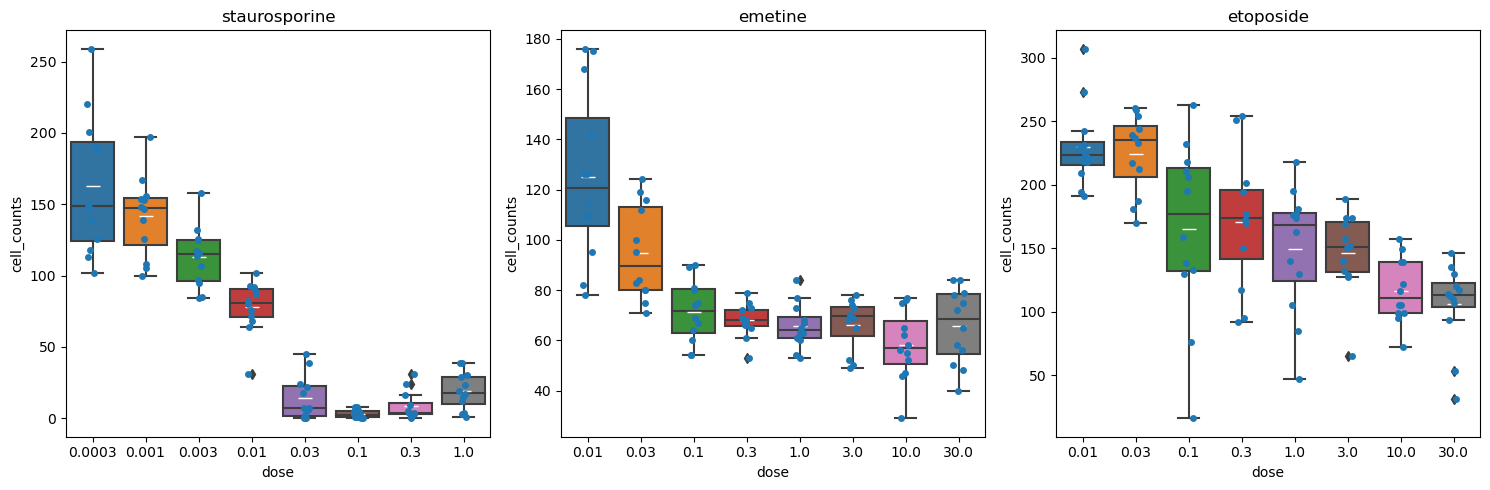

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

for i, cpd in enumerate(cpds):
    doses = []
    cell_cnts = []
    cntrs = np.sort(meta.query("Image_Metadata_Compound == @cpd")["Image_Metadata_Concentration"].unique())
    for cntr in tqdm(cntrs, desc=f"{cpd}"):
        img_paths = glob.glob(f"imgs/DAPI/{cpd}/{cntr}/*")
        doses.extend([cntr]*len(img_paths))
        for ip in img_paths:
            cnts = cell_count_contour(ip, mask_th=40, cnt_th=125, show_plot=False, verbouse=False)
            cell_cnts.append(cnts)

    df = pd.DataFrame({"dose": doses, "cell_counts": cell_cnts})
    ## Boxplot
    sns.boxplot(x="dose", y="cell_counts", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}, ax=ax[i]).set_title(f"{cpd}")
    sns.stripplot(x='dose', y='cell_counts', data=df, jitter=True, ax=ax[i])

plt.tight_layout()
plt.show()

### ImageJ macro based

As it requires some resources to run the cell pose model in all images, we won't do it here.<br>
Instead, let's run the same ImageJ macro we used above but in bulk. Simply we need to run `cell_cnts_batch.ijm` macro on the ImageJ application. <br>
As same as before, this macro will ask you first the input and output directory. If you successfully located the unzipped images as instructed above, those should be `./imgs/DAPI/` and `outs/`. If you choose them properly, ImageJ will run the processing in bulk and save the results in `outs` directory.<br>

Below is a script to collect those computed results and plot the proliferation curves. In case of ImageJ, we also computed the cell area, so we will visualize the proliferation curves based on both cell counts and cell areas.

outs/staurosporine/0.1/Week3_290607_C05_s4_w151A3ADED-000C-477C-8C51-5DD96C85A6E8_results.csv


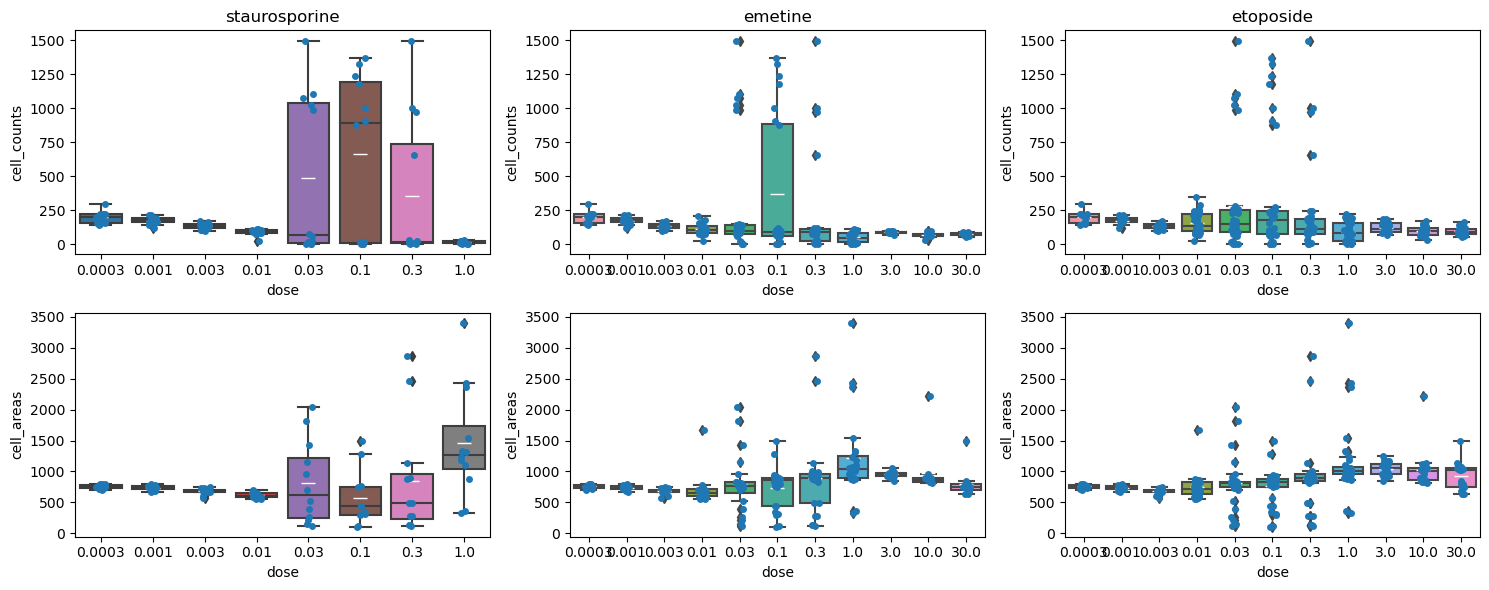

In [10]:
doses = []
cnts = []
areas = []
fig, ax = plt.subplots(2,3,figsize=(15,6))
for i, cpd in enumerate(cpds):
    pths = glob.glob(f"outs/{cpd}/*/*.csv")  # If you select the `outs` directory for the output. If not please change accordingly.
    for p in pths:
        # print(p)
        df = pd.read_csv(p, index_col=0)
        doses.append(float(p.split('/')[-2]))
        cnts.append(len(df))
        areas.append(df["Area"].mean())
        if np.isnan(df["Area"].mean()):
            print(p)
    df = pd.DataFrame({"dose": doses, "cell_counts": cnts, "cell_areas": areas})
    ## Cell counts boxplot
    sns.boxplot(x="dose", y="cell_counts", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}, ax=ax[0,i]).set_title(f"{cpd}")
    sns.stripplot(x='dose', y='cell_counts', data=df, jitter=True, ax=ax[0,i])
    ## Cell areas boxplot
    sns.boxplot(x="dose", y="cell_areas", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}, ax=ax[1,i])
    sns.stripplot(x='dose', y='cell_areas', data=df, jitter=True, ax=ax[1,i])
plt.tight_layout()
plt.show()


Hmm,,, looks like something is wrong. There are extreme outliers both in cell counts and areas. Let's check inside.<br>
As an example, we check the pre-computed images by ImageJ for 0.03 concentration of staurosporine.

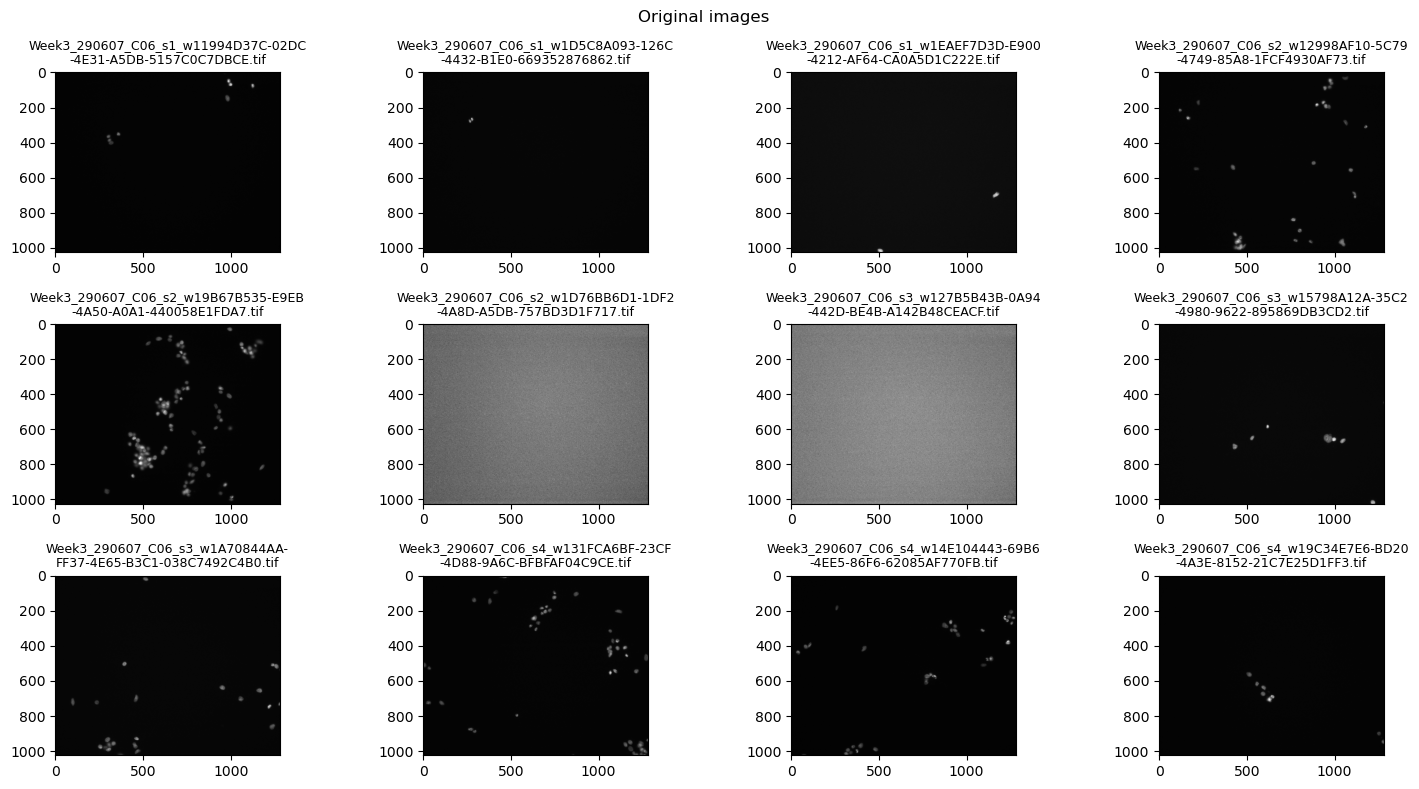

In [11]:
pth = "./imgs/DAPI/staurosporine/0.03"
img_pths = sorted(glob.glob(f"{pth}/*.tif"))
fig, ax = plt.subplots(3,4,figsize=(15,8))
for i, img_pth in enumerate(img_pths):
    row = i//4
    col = i%4
    img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)
    img = ((img - img.min()) / (img.max() - img.min())) * 255
    ax[row,col].imshow(img, cmap="gray")
    ax[row,col].set_title("\n".join(wrap(img_pth.split('/')[-1], 35)), fontsize=9)
    # print(img_pth)

plt.suptitle("Original images")
plt.tight_layout()
plt.show()


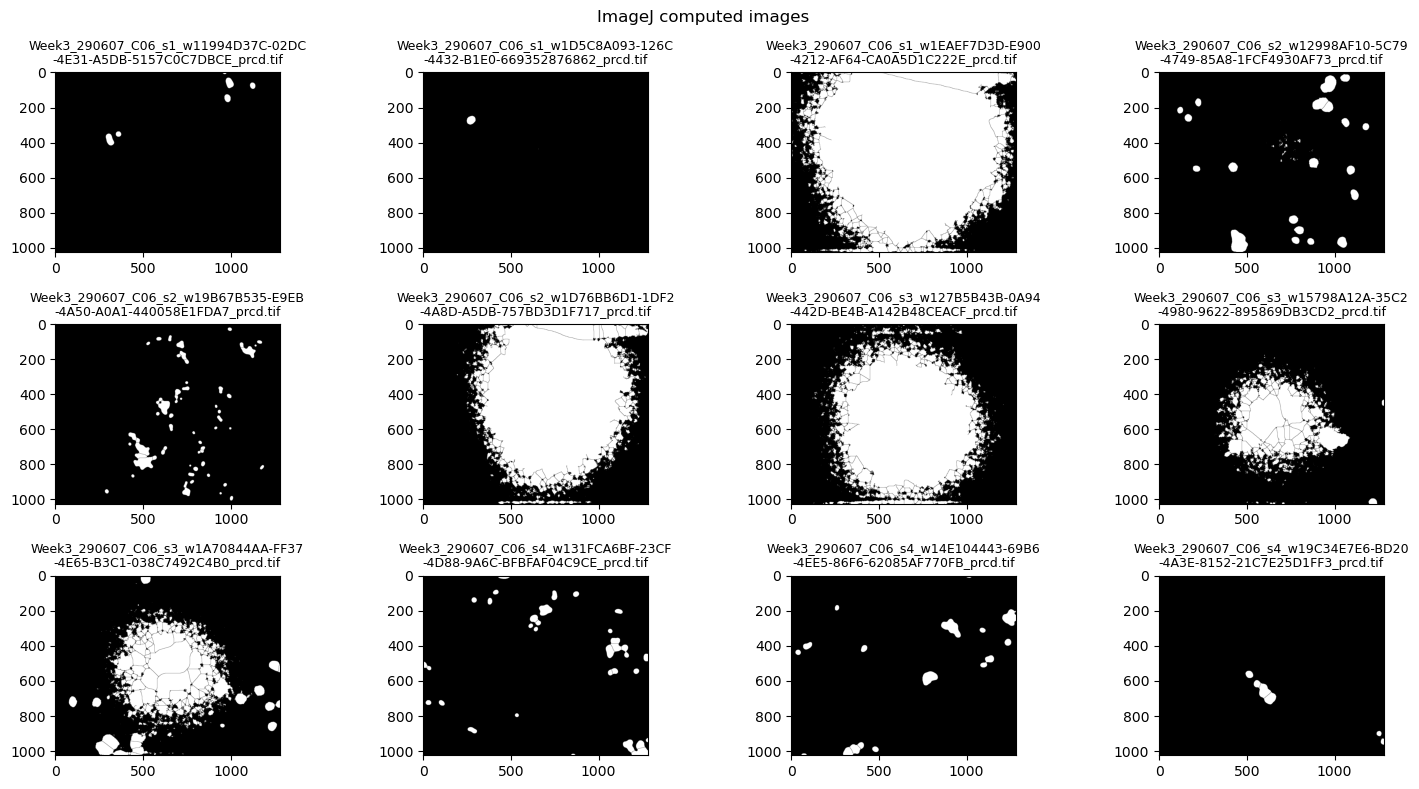

In [12]:
pth = "./outs/staurosporine/0.03"
img_pths = sorted(glob.glob(f"{pth}/*.tif"))
fig, ax = plt.subplots(3,4,figsize=(15,8))
for i, img_pth in enumerate(img_pths):
    row = i//4
    col = i%4
    img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)
    ax[row,col].imshow(img, cmap="gray")
    ax[row,col].set_title("\n".join(wrap(img_pth.split('/')[-1], 35)), fontsize=9)

plt.suptitle("ImageJ computed images")
plt.tight_layout()
plt.show()


Ohh, now we know what was wrong. As the concentration gets higher, less cells are remaining. When we do `thesholding` in imageJ, we need to set a threshold value to make an image binary. In the above example, we used `Default` method for thresholding, but now let's try `Otsu` method.<br>
Just as same as the previous step, but now using `cell_cnts_batch_otsu.ijm` script will generate the results. Please save them in a separate directory.


With `Otsu` method, thresholding works much better! Except two images in the middle, all segmentations are properly according to the original images.<br>
Regarding the middle two images, the original images are already saturated, it can be interpreted there is no cell alive thus flourecence markers. For those images, for now we take them as outliers.

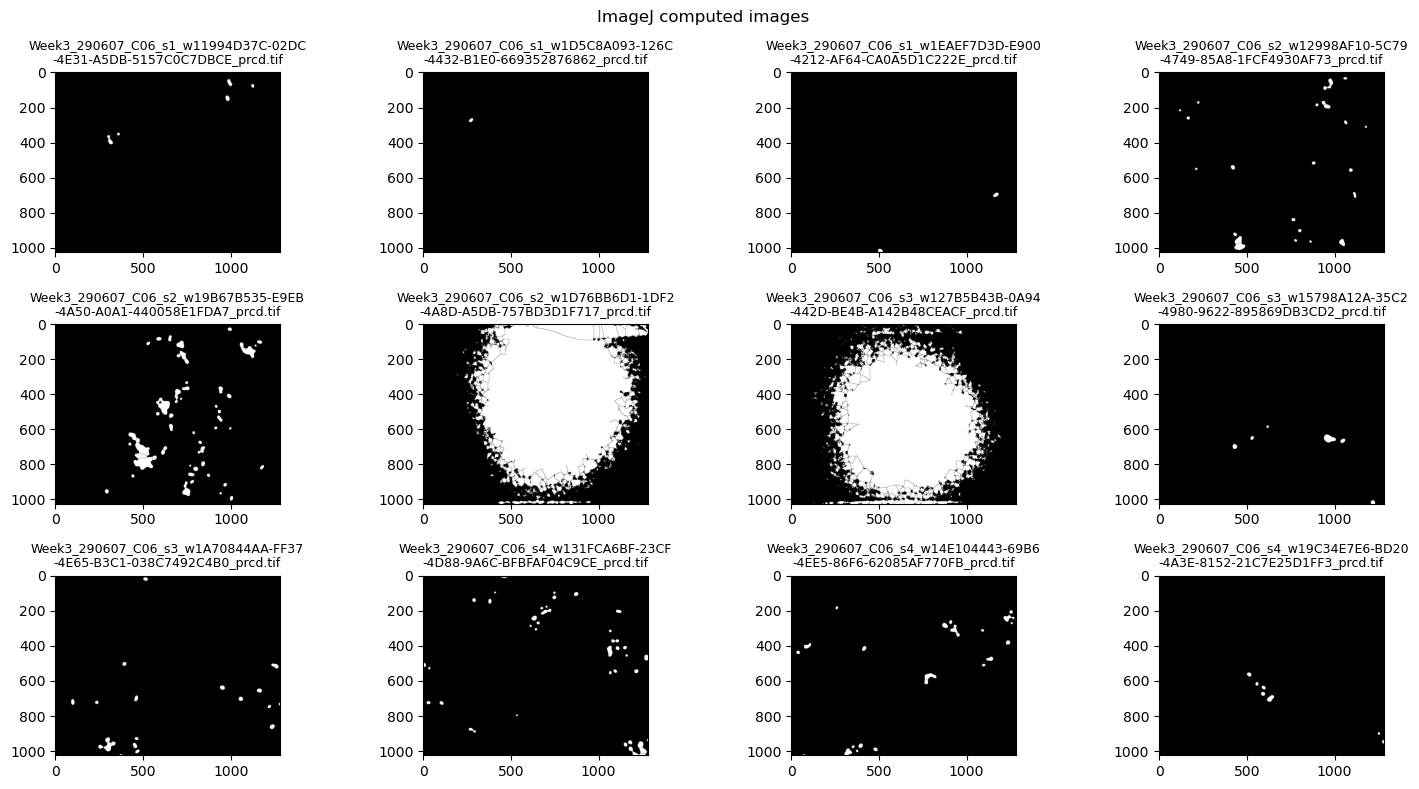

In [13]:
pth = "./outs/otsu/staurosporine/0.03"
img_pths = sorted(glob.glob(f"{pth}/*.tif"))
fig, ax = plt.subplots(3,4,figsize=(15,8))
for i, img_pth in enumerate(img_pths):
    row = i//4
    col = i%4
    img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)
    ax[row,col].imshow(img, cmap="gray")
    ax[row,col].set_title("\n".join(wrap(img_pth.split('/')[-1], 35)), fontsize=9)

plt.suptitle("ImageJ computed images")
plt.tight_layout()
plt.show()


Finally, we applied `cell_cnts_batch_otsu.ijm` script to all images, and got all pre-computed values and plot them again. We avoid showing outliers here which may come from those saturated original images to show clearler results.

outs/otsu/staurosporine/0.1/Week3_290607_C05_s4_w151A3ADED-000C-477C-8C51-5DD96C85A6E8_results.csv


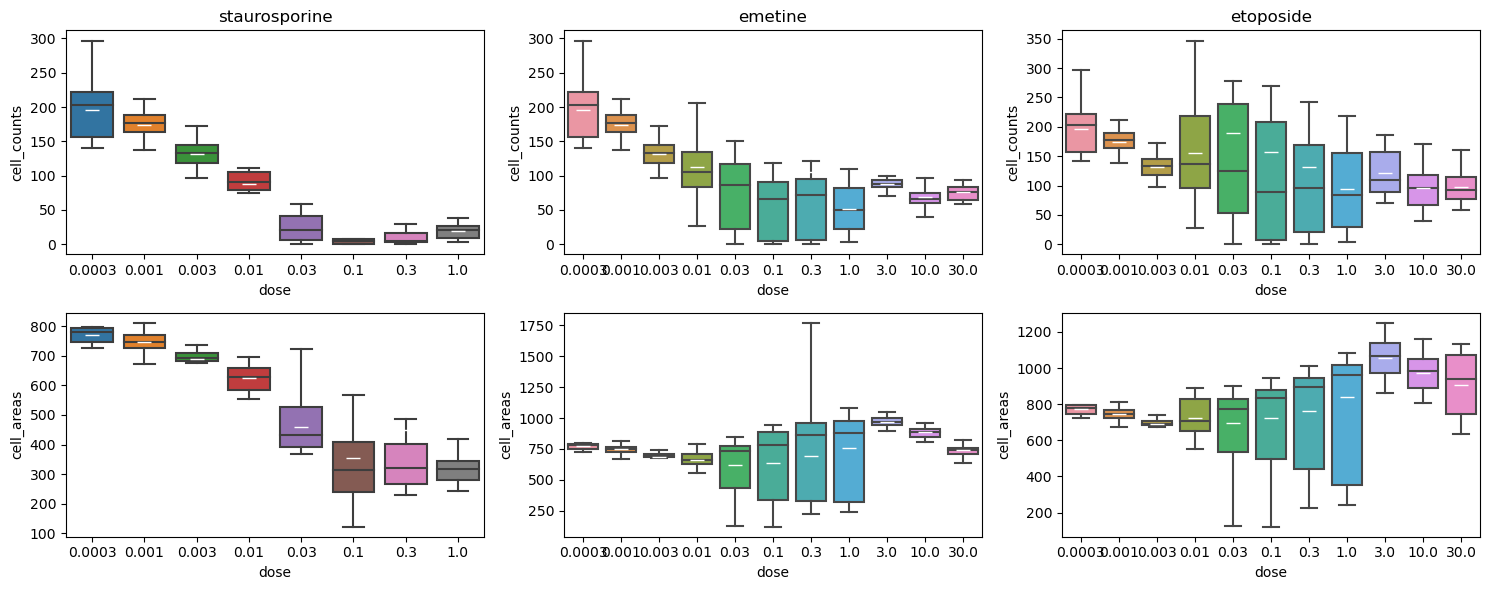

In [14]:
doses = []
cnts = []
areas = []
fig, ax = plt.subplots(2,3,figsize=(15,6))
for i, cpd in enumerate(cpds):
    pths = glob.glob(f"outs/otsu/{cpd}/*/*.csv")
    for p in pths:
        # print(p)
        df = pd.read_csv(p, index_col=0)
        doses.append(float(p.split('/')[-2]))
        cnts.append(len(df))
        areas.append(df["Area"].mean())
        if np.isnan(df["Area"].mean()):
            print(p)
    df = pd.DataFrame({"dose": doses, "cell_counts": cnts, "cell_areas": areas})
    ## Cell counts boxplot
    sns.boxplot(x="dose", y="cell_counts", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}, ax=ax[0,i], showfliers=False).set_title(f"{cpd}")
    # sns.stripplot(x='dose', y='cell_counts', data=df, jitter=True, ax=ax[0,i])
    ## Cell areas boxplot
    sns.boxplot(x="dose", y="cell_areas", data=df, showmeans=True, dodge=True, meanprops={"marker":"_", "markeredgecolor":"white", "markersize":"10"}, ax=ax[1,i], showfliers=False)
    # sns.stripplot(x='dose', y='cell_areas', data=df, jitter=True, ax=ax[1,i])
plt.tight_layout()
plt.show()


## Summary

In this notebook, we went through three different methods to perform cell segmentation based on the microscopic images, namely, python-algorithm, cell pose (deep learning), and imageJ macro-based methods. On a single image trial, all methods works properly and returned similar cell counting values (returned value from cell pose looks a little higher though). <br>
Next, we run the same algorithms on the bulk set of images for three compounds with eight concentrations per each. Then we approximated the cell proliferation curves. We haven't done it for cell pose since it will require some computational resources for bulk inferencing.<br>
The results were pretty sound. As expected, it shows decreasing trend as the concentration gets higher for both python-algo and imageJ macro based scripts. The only failure from the imageJ macro script was that the default threshold setting doesn't work properly sometimes. So we switched to use `Otsu` method then we got an improved result.<br>
Below, we repost the approximated proliferation curve from python-based (above) and imageJ-based (below). Regarding cell counting, both scripts successfully resulted in the decreasing curve and showing the similar results. As for cell areas, it looks outlier effects is more severe than cell counting and a little weired increasing trend for emetine and etoposide from around 0.1/0.3 concentrations. Presumably, it may be because as the concentration gets higher more residues appear in the image that makes segmentation difficult. Some cells and residues may be concatenated during thresholding process. And this may result in the higher cell area measurement.


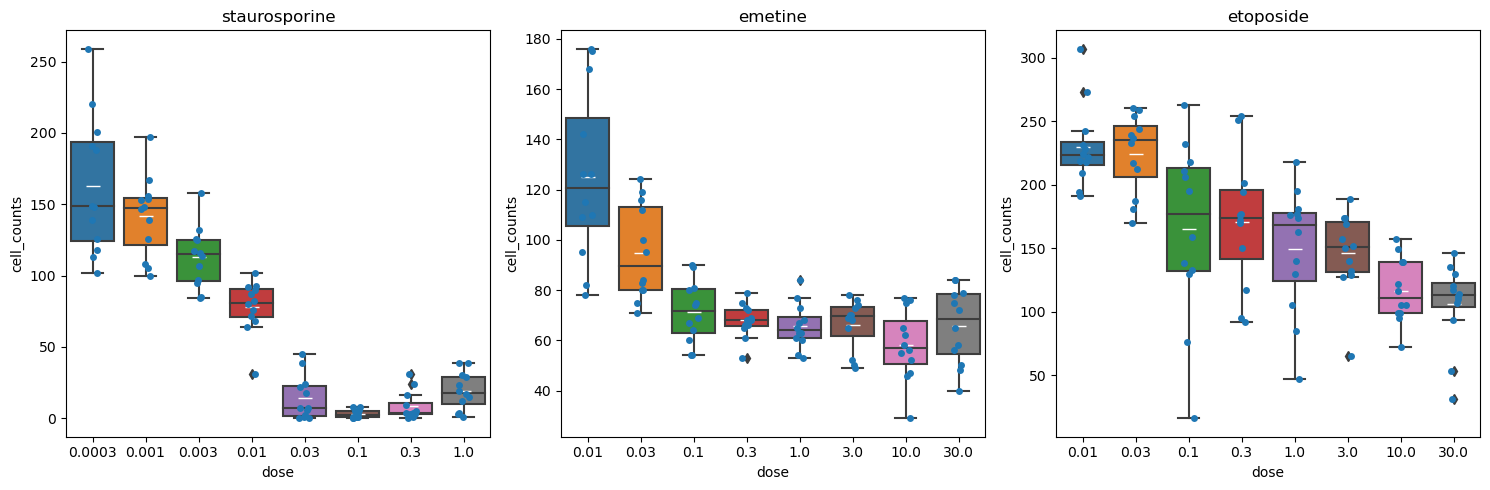
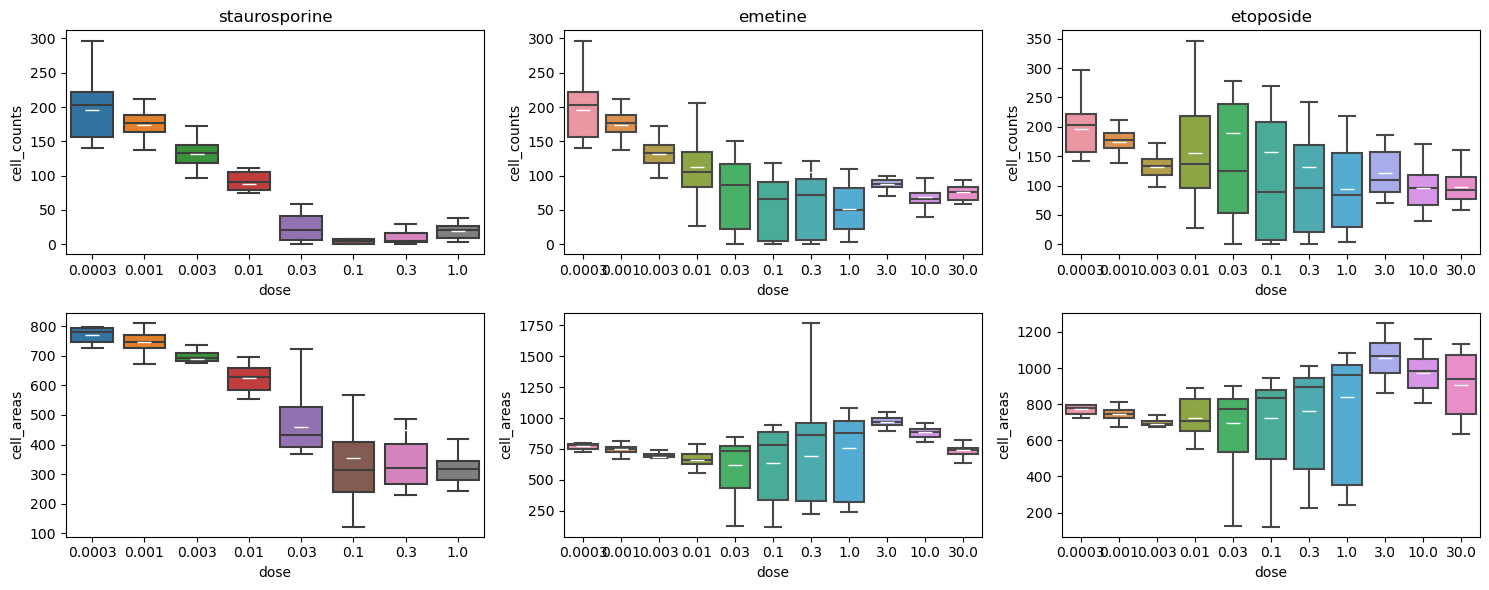